# Predictive Modelling: cross-validation

# <font color=red> In previous weeks:

## Build, train and test predictive models

### a. Stepwise and regularized approaches
    
### b. Test set: hold-out approach
    
    - Split the data in 2: training and test (or validation) set 
    
    - Build and train the model on the training set
    
    - Test its performance on the left-out test set

# <font color=red> Today:

### a. Advantages and desadvantages of variable selection methods
    
### b. Cross-validation
   

## Dataset

In this section we will work with a richer real estate dataset, the [Ames `Housing` dataset](https://www.kaggle.com/c/home-data-for-ml-course/), compiled by Dean De Cock. It has 79 input variables on different characteristics of residential houses in Ames, Iowa, USA that can be used to predict the property's final price, `SalePrice`. We will use a subset of 21 continuous input variables:

- `LotFrontage`: Linear $\text{ft}$ of street connected to the house.
- `LotArea`: Lot size in $\text{ft}^2$.
- `MasVnrArea`: Masonry veneer area in $\text{ft}^2$.
- `TotalBsmtSF`: Total $\text{ft}^2$ of basement area.
- `GrLivArea`: Above grade (ground) living area in $\text{ft}^2$.
- `BsmtFullBath`: Number of full bathrooms in basement.
- `BsmtHalfBath`: Number of half bathrooms in basement.
- `FullBath`: Number of full bathrooms above grade.
- `HalfBath`: Number of half bathroom above grade.
- `BedroomAbvGr`: Number of bedrooms above grade (it does not include basement bedrooms).
- `KitchenAbvGr`: Number of kitchens above grade.
- `Fireplaces`: Number of fireplaces.
- `GarageArea`: Garage's area in $\text{ft}^2$.
- `WoodDeckSF`: Wood deck area in $\text{ft}^2$.
- `OpenPorchSF`: Open porch area in $\text{ft}^2$.
- `EnclosedPorch`: Enclosed porch area in $\text{ft}^2$.
- `ScreenPorch`: Screen porch area in $\text{ft}^2$.
- `PoolArea`: Pool area in $\text{ft}^2$.

The following variables will be used to construct a variable `ageSold`
- `YearBuilt`: Original construction date.
- `YrSold`: Year sold.

Run this code to prepare a working dataset

In [2]:
library(broom)
library(tidymodels)
library(tidyverse)
library(repr)
library(digest)
library(faraway)
library(mltools)
library(leaps)
library(glmnet)
library(caret)

options(repr.plot.width=6, repr.plot.height=5)

── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ dials        1.2.0     ✔ rsample      1.2.0
✔ dplyr        1.1.4     ✔ tibble       3.2.1
✔ ggplot2      3.4.4     ✔ tidyr        1.3.0
✔ infer        1.0.5     ✔ tune         1.1.2
✔ modeldata    1.2.0     ✔ workflows    1.1.3
✔ parsnip      1.1.1     ✔ workflowsets 1.0.1
✔ purrr        1.0.2     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ purrr::discard() masks scales::discard()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
✖ recipes::step()  masks stats::step()
• Learn how to get started at https://www.tidymodels.org/start/

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ readr     2.1.4
✔ lubridate 1.9.3     ✔ stringr   1.5.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ readr::col_factor(

In [3]:
Housing <- read_csv("data/Housing.csv")

# Use `YearBuilt` and `YrSold` to create a variable `ageSold`
Housing$ageSold <- Housing$YrSold - Housing$YearBuilt


# Select subset of input variables
Housing <- Housing %>%
  select(
    LotFrontage, LotArea, MasVnrArea, TotalBsmtSF, 
    GrLivArea, BsmtFullBath, BsmtHalfBath, FullBath, HalfBath, BedroomAbvGr, KitchenAbvGr, Fireplaces,
    GarageArea, WoodDeckSF, OpenPorchSF, EnclosedPorch, ScreenPorch, PoolArea, ageSold, SalePrice
  )

# Remove those rows containing `NA`s and some outliers
Housing <- drop_na(Housing)  %>% 
            filter(LotArea < 20000)

Rows: 1460 Columns: 81
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (43): MSZoning, Street, Alley, LotShape, LandContour, Utilities, LotConf...
dbl (38): Id, MSSubClass, LotFrontage, LotArea, OverallQual, OverallCond, Ye...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## a. Advantages and Disadvantages

**Stepwise algorithms**

- only partial contribution of variables is considered

- once variables are selected they are not re-evaluated

- they can't be used when $n < p$

- they can be used with categorical variables but not implemented in `regsubsets`

**Regularized Methods**

- contributions of all variables are jointly considered

- variables are not permanently selected or discarded 

- they can be used when $n << p$

- they can be used with categorical variables but not implemented in `glmnet`. Algorithms that consider groups of variables are needed, e.g., group LASSO.


## b. Recall: hold-out

Let's start by reviewing the results of the "hold-out" method to estimate the **test Root Mean Squared Error (RMSE)**:

In [4]:
set.seed(1234)

# Training LS

train=sample(nrow(Housing), round(nrow(Housing) * 0.60))
Housing_train_LS <- lm(SalePrice ~ .,
                        data = Housing,subset = train)

# Test the estimated model

Housing_test_LS <- predict(Housing_train_LS, 
                           Housing)[-train]

In [6]:
# Test RMSE

RMSE_method = tibble(
  Method = "Hold-out",
  RMSE = round(rmse(
    preds = Housing_test_LS,
    actuals = Housing$SalePrice[-train]
  ),
               3))

RMSE_method

Method,RMSE
<chr>,<dbl>
Hold-out,34686.05


### Limitations

- The estimate of the population test error rate depends on the split of the dataset. Thus, it can be highly variable.

- Only a *subset* of the observations (included in the training set) are used to fit the model (smaller sample size). Thus, this approach tends to overestimate the population test error rate.

Let's illustrate the variation associated with different splits of the data:

In [7]:
rmse_holdout <- function(dataset, prop, Y){
    train=sample(nrow(dataset), round(nrow(dataset) * prop))
    train_LS <- lm(Y ~ ., data = dataset,subset =train)

# Test the estimated model
    test_LS <- predict(train_LS, dataset)[-train]
holdout.rmse <- round(rmse(
    preds = test_LS,
    actuals = dataset$Y[-train],
    3)) 
    
return(holdout.rmse)
    }

In [10]:
set.seed(1234)

# Training LS

holdout.rmse= rep (0 ,100)

for (i in 1:100){
train=sample(nrow(Housing), round(nrow(Housing) * 0.60))
Housing_train_LS <- lm(SalePrice ~ .,
                        data = Housing,subset =train)

# Test the estimated model
Housing_test_LS <- predict(Housing_train_LS, 
                           Housing)[-train]
holdout.rmse[i] <- round(rmse(
    preds = Housing_test_LS,
    actuals = Housing$SalePrice[-train],
    3))
    
    }

RMSE <- tibble(
 Method = "Hold-out",
  RMSE = holdout.rmse)

head(RMSE,3)

Warning message in predict.lm(Housing_train_LS, Housing):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(Housing_train_LS, Housing):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(Housing_train_LS, Housing):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(Housing_train_LS, Housing):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(Housing_train_LS, Housing):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(Housing_train_LS, Housing):
“prediction from a rank-deficient fit may be misleading”


Method,RMSE
<chr>,<dbl>
Hold-out,34686
Hold-out,36474
Hold-out,36581


#### Plot

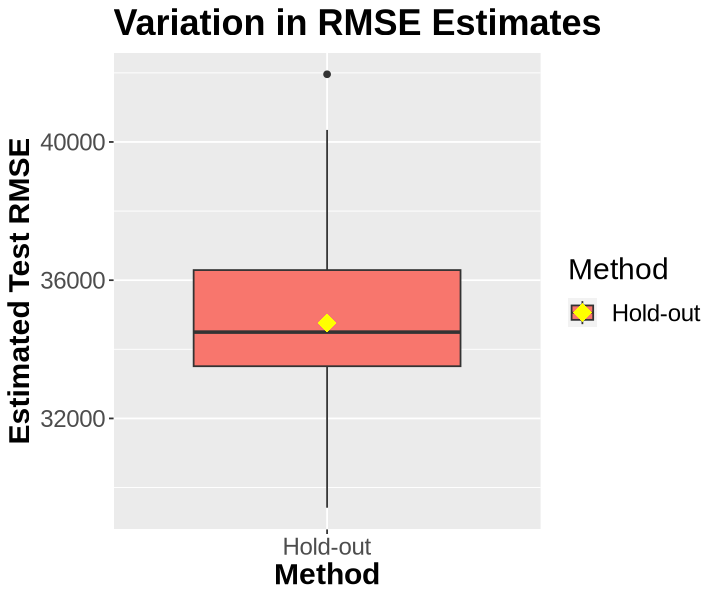

In [11]:
RMSE_boxplot <- RMSE %>%
  ggplot() +
  geom_boxplot(aes(Method, RMSE, fill = Method)) +
  theme(
    text = element_text(size = 18),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold")
  ) +
  ggtitle("Variation in RMSE Estimates") +
  xlab("Method") +
  ylab("Estimated Test RMSE") +
  stat_summary(aes(Method, RMSE, fill = Method),
    fun = mean, colour = "yellow", geom = "point",
    shape = 18, size = 5
  )
RMSE_boxplot 

#### Randomness: 

Note there are several ways of partioning the data into 2 parts!! Since results depend on the partion used, we need to make several partitions!

## Cross-validation

To address the limitation of the hold-out method, we can partition the data differently and:

- use more observations in the training set

- consider different training sets with different subset of observations

### k-fold CV:

- Split the data into $k$-folds
    
- Leave one fold aside as a test set

- Build and train the model on the remaining $(k-1)$ folds (training set)
    
- Estimate the test MSE using the left-out fold: CV$_i$
    
- Repeat the last 3 steps until *all* folds are used as a test set

As a result, you'll get $k$ estimates of the MSE which you can average

> Note: this is what cv.glmnet uses to select $\lambda$

- Except for $k = 1$ and $k = n$, there is randomness in this procedure since there's not a unique way to partition the data into $k$ folds

<img src="https://github.com/UBC-STAT/stat-301/blob/master/supplementary-material/img/CV.png?raw=true" width=500>

#### Randomness: 

Note there are several ways of partioning the data into (approximately) 3 parts!! Since results depend on the partion used, we need to run the CV multiple times!

> except when $k = N$, a.k.a leave-one-out CV (see below)

### CV-MSE: estimate of the test MSE using CV

Note that at the end we have $k$ estimates (3 in this particular example) of the test MSE, one for each fold left out!

$$\text{CV-MSE} = \frac{1}{k}\sum_{j=1}^k \text{MSE}_j$$

### CV-RMSE: estimate of the test RMSE using CV

Note that we have 2 approaches in this case:

1) $\text{CV-RMSE} = \sqrt{\text{CV-MSE}} = \sqrt{\frac{1}{k}\sum_{j=1}^k \text{MSE}_j}$


2) $\text{CV-RMSE} = \frac{1}{k}\sum_{j=1}^k \text{RMSE}_j = \frac{1}{k}\sum_{j=1}^k \sqrt{\text{MSE}_j}$


> the package `caret` implements option 2

#### <font color=red> Leave-one-out CV (LOOCV): </font> a particular case of k-fold CV is the n-fold CV
    
> in a LOOCV, each fold has only 1 observation. 

- The test set of the LOOCV has only one observation to estimate the MSE!

> The estimate of the MSE is highly variable, since it is based upon a single observation!


- The training set of the LOOCV has (n-1) observations!! Very similar to the full set!


- There is no randomness in the training/validation set splits

Let's write a code to estimate the RMSE using LOOCV:

In [14]:
#LOOCV

N <- nrow(Housing)
loocv.rmse= rep (0, N)

for (i in 1:N){
train=c(1:N)[-i]
Housing_train_LS <- lm(SalePrice ~ .,
                        data = Housing,subset = train)

# Test the estimated model
Housing_test_LS <- predict(Housing_train_LS, 
                           Housing)[-train]
loocv.rmse[i] <- round(rmse(
    preds = Housing_test_LS,
    actuals = Housing$SalePrice[-train]),3)
    
    }

RMSE <- rbind(RMSE,tibble(
 Method = "LOOCV",
  RMSE = loocv.rmse))

We can see that each estimate is highly variable:

In [15]:
tail(RMSE,3)

Method,RMSE
<chr>,<dbl>
LOOCV,55550.347
LOOCV,1692.987
LOOCV,15571.335


In [16]:
# LOOCV-RMSE

RMSE_LOOCV <- RMSE  %>% filter(Method == "LOOCV") %>% 
           summarize(mean = mean(RMSE))
RMSE_LOOCV

mean
<dbl>
23283.24


## Using the package `caret`:

### LOOCV-RMSE

In [17]:
# define training control
train_control <- trainControl(method="cv", number = N)

# train the model
model_LOOCV <- train(SalePrice~., data = Housing, 
               trControl=train_control, method="lm")

# summarize results
print(model_LOOCV)

Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


Linear Regression 

1162 samples
  19 predictor

No pre-processing
Resampling: Cross-Validated (1162 fold) 
Summary of sample sizes: 1161, 1161, 1161, 1161, 1161, 1161, ... 
Resampling results:

  RMSE      Rsquared  MAE     
  23283.24  NaN       23283.24

Tuning parameter 'intercept' was held constant at a value of TRUE


### 10-fold CV-RMSE

Let's use `caret` to estimate to run a 10-fold CV

> recall that results depend on the random split into 10 folds!

In [18]:
# define training control
train_control <- trainControl(method="cv", number = 10)

# train the model
model_10CV <- train(SalePrice~., data = Housing, 
               trControl=train_control, method="lm")

# summarize results
print(model_10CV)

Linear Regression 

1162 samples
  19 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 1045, 1047, 1046, 1045, 1046, 1046, ... 
Resampling results:

  RMSE     Rsquared   MAE     
  33381.7  0.8212842  23277.92

Tuning parameter 'intercept' was held constant at a value of TRUE


## Using `tidymodels`

<img src="https://datasciencebook.ca/img/classification2/cv.png" width=500>

From [Data Science: A First Introduction](https://datasciencebook.ca/)

In [19]:
#N = nrow(Housing)
N=3

housing_vfold <- vfold_cv(Housing, v = N, strata = SalePrice)

lm_spec <- linear_reg() |>
  set_engine("lm") |>
  set_mode("regression")

housing_recipe <- recipe(SalePrice ~ ., 
                        data = Housing)

# fit LS to each training fold created in housing_vfold
housing_fit <- workflow() |>
  add_recipe(housing_recipe) |>
  add_model(lm_spec) |>
  fit_resamples(resamples = housing_vfold) 

housing_fit|> 
  collect_metrics() 

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
rmse,standard,3.391648e+04,3,1.069087e+03,Preprocessor1_Model1
rsq,standard,8.178122e-01,3,5.084259e-03,Preprocessor1_Model1


### Comparison of different methods

We can compare the variation of all methods due to different splits of the data

In [20]:
set.seed(123)

RMSE <- tibble(
 Method = "LOOCV",
  RMSE = model_LOOCV$results$RMSE)

for (i in 1:100){
    
## Hold-out    
train=sample(nrow(Housing), round(nrow(Housing) * 0.60))
Housing_train_LS <- lm(SalePrice ~ .,
                        data = Housing,subset =train)

Housing_test_LS <- predict(Housing_train_LS, 
                           Housing)[-train]
holdout.rmse <- round(rmse(
    preds = Housing_test_LS,
    actuals = Housing$SalePrice[-train]),3)

# add hold-out estimate to tibble    
RMSE <- rbind(RMSE,tibble(
 Method = "Hold-out",
  RMSE = holdout.rmse))
    
## 10-fold CV    
    
train_control <- trainControl(method="cv", number = 10)

# train the model
model_10CV <- train(SalePrice~., data = Housing, 
               trControl=train_control, method="lm")    
    

RMSE <- rbind(RMSE,tibble(
 Method = "10-foldCV",
  RMSE = model_10CV$results$RMSE))
    }

Warning message in predict.lm(Housing_train_LS, Housing):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(Housing_train_LS, Housing):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(Housing_train_LS, Housing):
“prediction from a rank-deficient fit may be misleading”
Warning message in predict.lm(Housing_train_LS, Housing):
“prediction from a rank-deficient fit may be misleading”


In [21]:
train=sort(sample(nrow(Housing), round(nrow(Housing) * 0.60)))
data_tr <- Housing[train,]
data_te <- Housing[- train,]

Housing_train_LS <- lm(SalePrice ~ .,
                        data = Housing[train,])

Housing_test_LS <- predict(Housing_train_LS, 
                           Housing[-train,])
holdout.rmse <- round(rmse(
    preds = Housing_test_LS,
    actuals = Housing$SalePrice[-train]),3)
holdout.rmse

[1] 32254.94

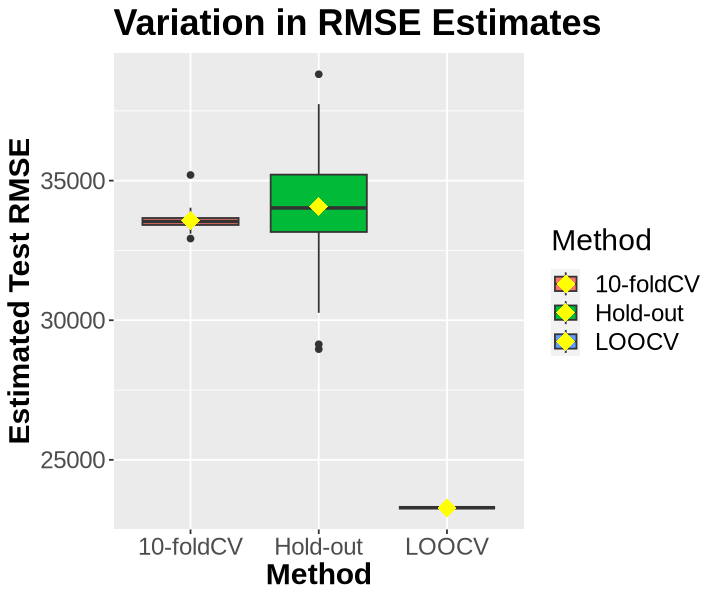

In [22]:
RMSE_boxplot <- RMSE %>%
  ggplot() +
  geom_boxplot(aes(Method, RMSE, fill = Method)) +
  theme(
    text = element_text(size = 18),
    plot.title = element_text(face = "bold"),
    axis.title = element_text(face = "bold")
  ) +
  ggtitle("Variation in RMSE Estimates") +
  xlab("Method") +
  ylab("Estimated Test RMSE") +
  stat_summary(aes(Method, RMSE, fill = Method),
    fun = mean, colour = "yellow", geom = "point",
    shape = 18, size = 5
  )
RMSE_boxplot 

### Other useful functions related to CV

There are other functions to perform CV but each has different arguments and are limited to some models. For example: `cv.glm()` in `boot` and `cv.glmnet()` in `glmnet`.

The advantage of `caret` is that it provides a unifying framework for many models.

- You can use `caret` to partion the data into training/test using `createDataPartition` 


- You can run many iterations of CV using `method = "repeatedcv"` and `repeat` arguments


- You can run a using `method = "LOOCV"`


- You can repeated training/test splits using `method = "LGOCV"`

### Additional comments

In this lecture, we've trained the LR using LS, a simple method that does not require any tuning. However, if we need to select additional arguments as in LASSO, for example, we need an additional *validation* set!! 

Methods that require the selection of additional parameters need to run a *nested* CV within each training set of the outer CV!!

> note that the function `cv.glmnet()` runs a CV to select the penalty parameter of LASSO and RIDGE. If we train the model $k_1$ times (one per data partition), we need to call this function $k_2$ time as well *within* each run.

<img src="https://github.com/UBC-STAT/stat-301/blob/master/supplementary-material/img/nestedCV.png?raw=true" width=500>